In [1]:
# The purpose of this notebook is to test the tflite models that were deployed to the android application in a more managable way.
# Following the project's guidelines 20 images, 50-50 % adult-elderly people, and also for each group 50-50% male-
# female, and 50-50% happy-sad were collected and saved in the evaluation_images folder.
#### Author: Hugo Albuquerque Cosme da Silva
#### Creation date: 2023-12-28

In [1]:
import tensorflow as tf
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

2023-12-31 21:40:25.459861: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-31 21:40:25.498636: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-31 21:40:25.498666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-31 21:40:25.499778: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-31 21:40:25.505893: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-31 21:40:25.506506: I tensorflow/core/platform/cpu_feature_guard.cc:1

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


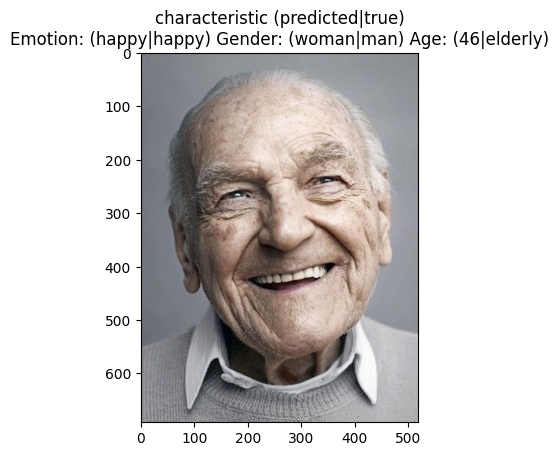

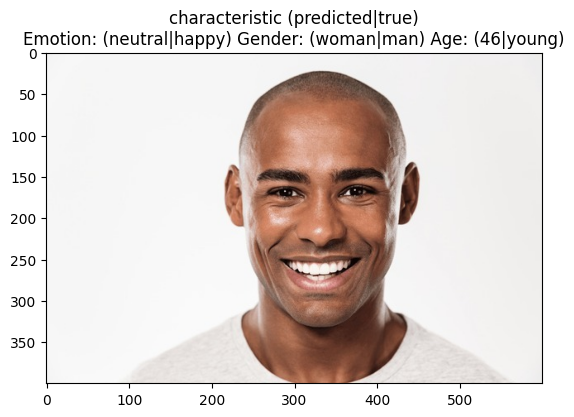

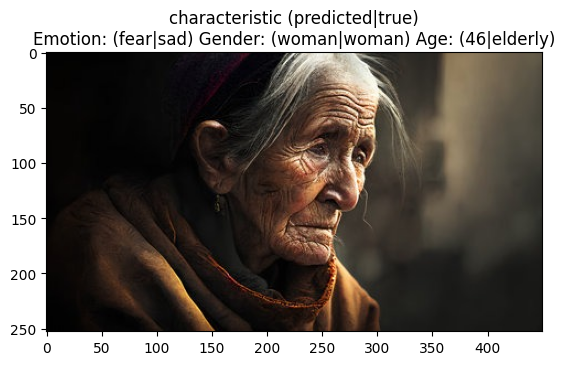

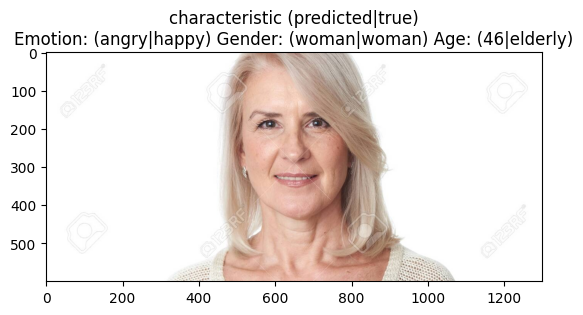

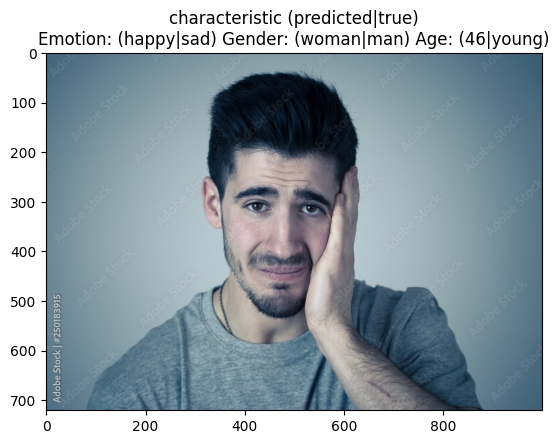

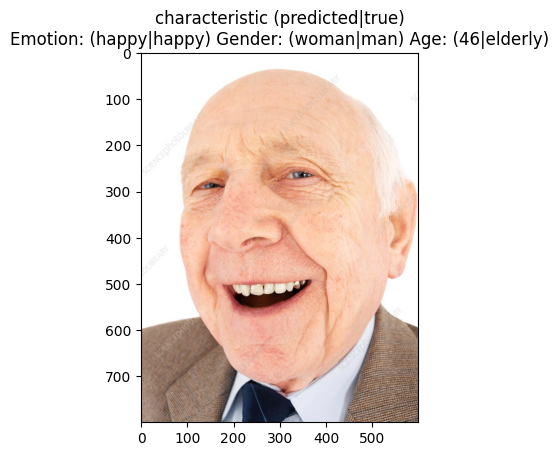

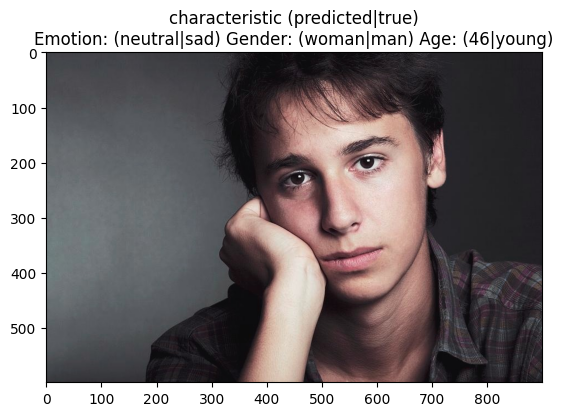

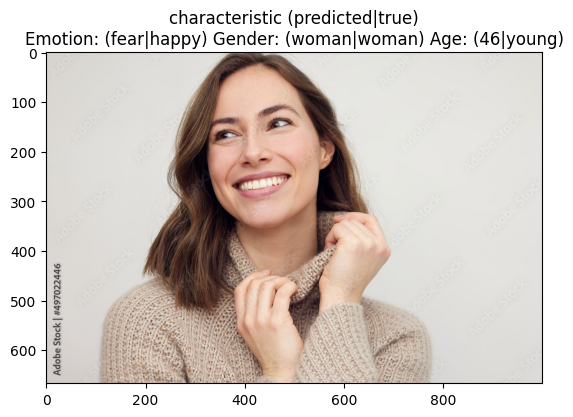

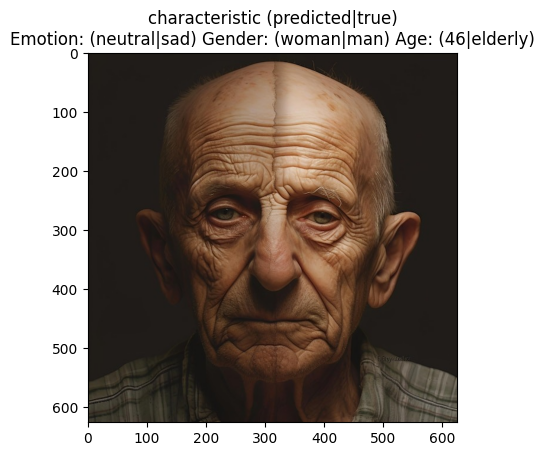

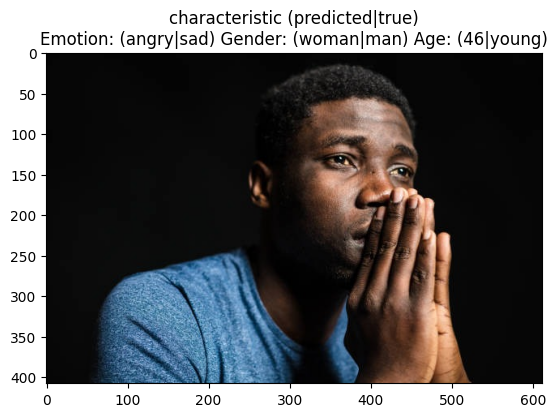

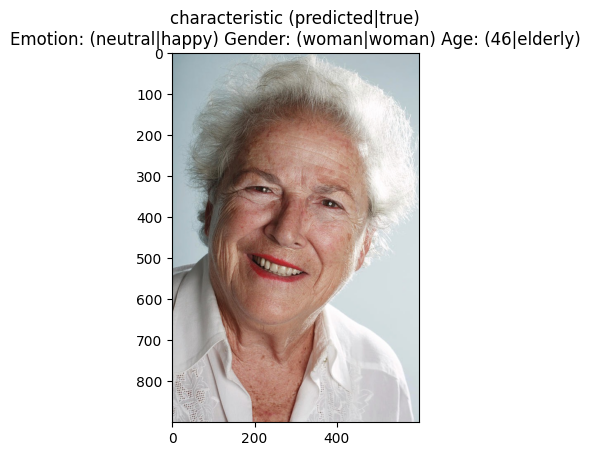

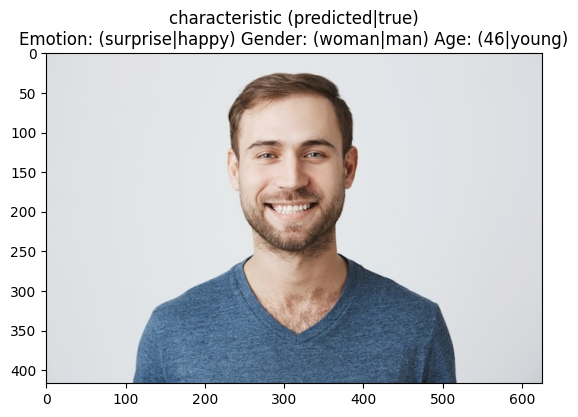

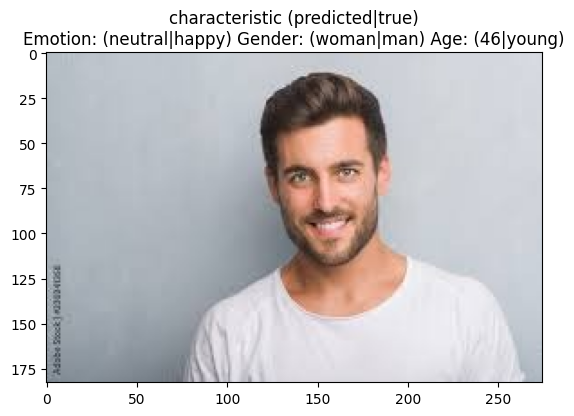

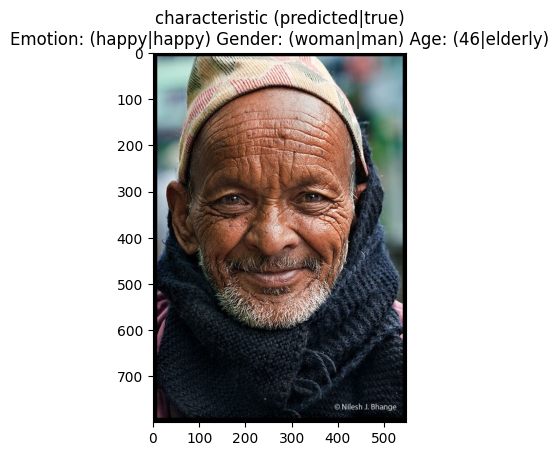

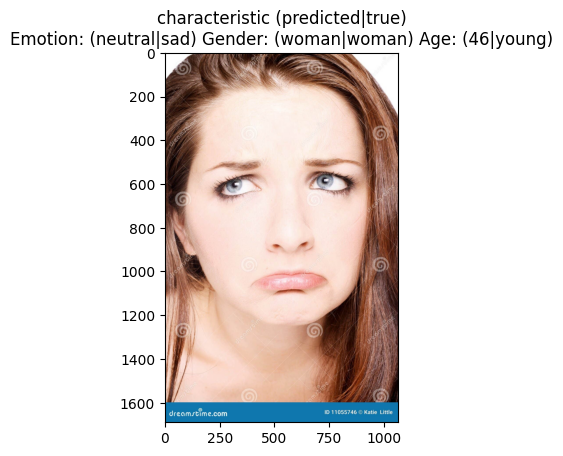

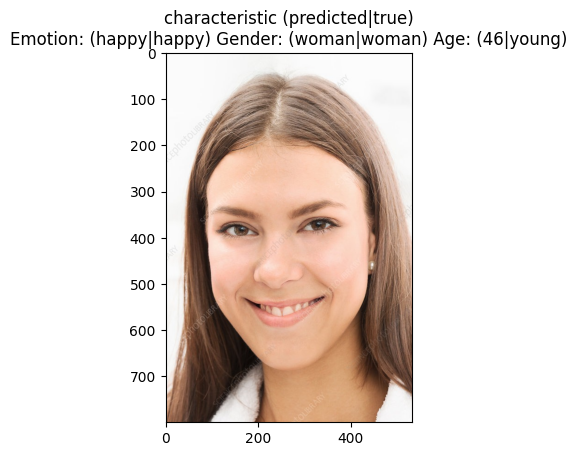

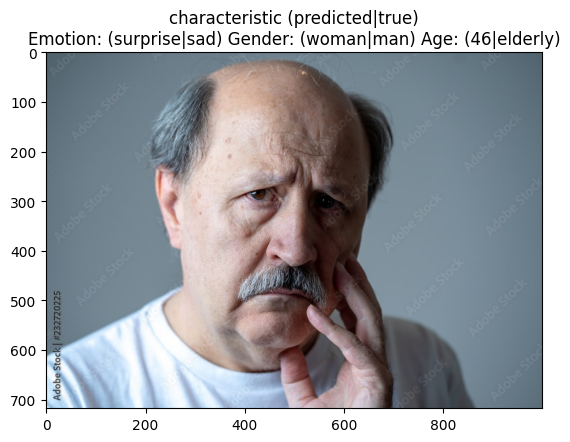

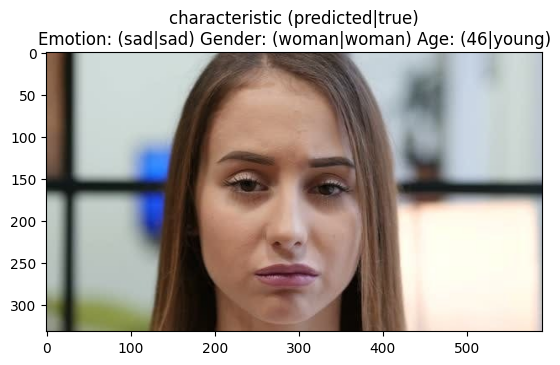

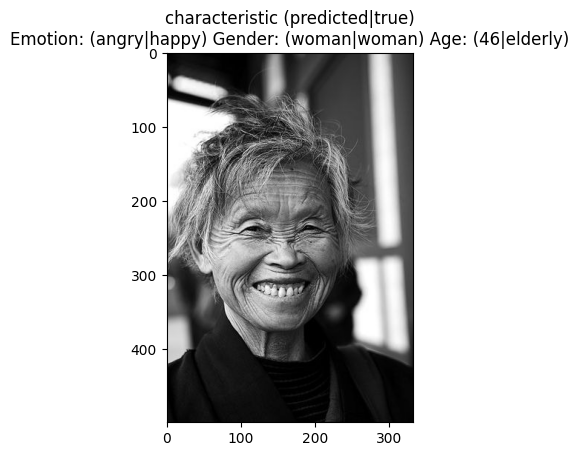

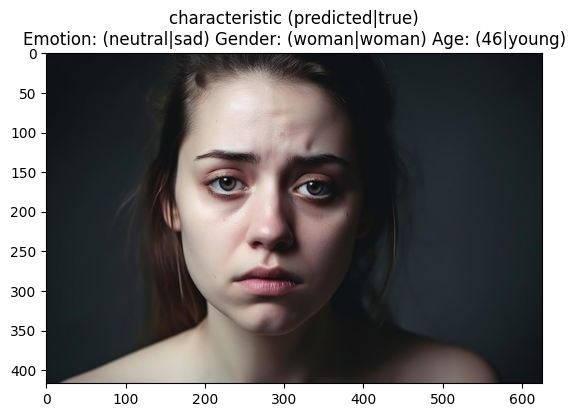

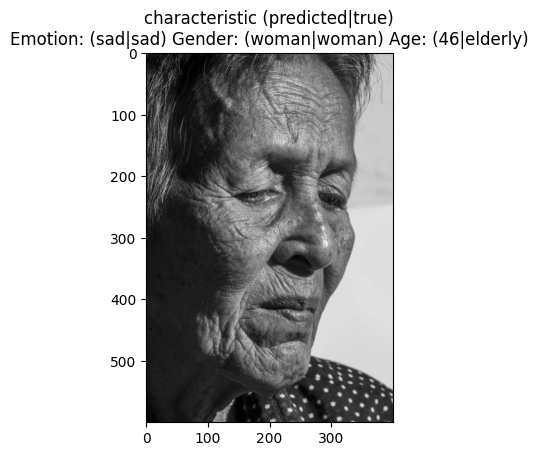

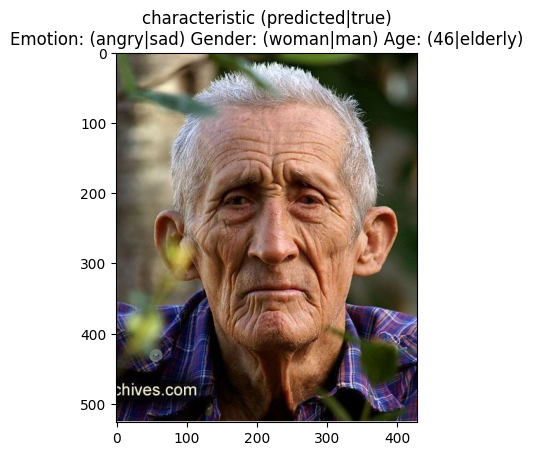

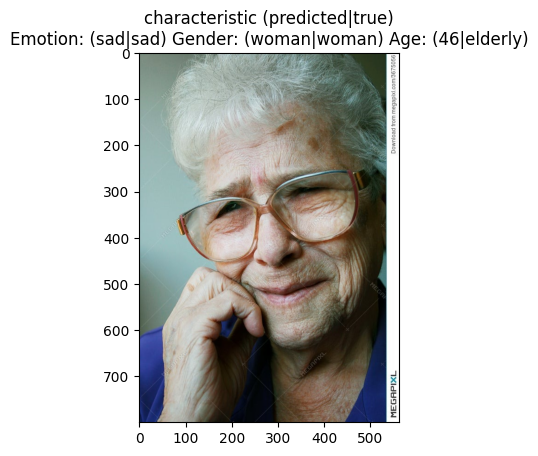

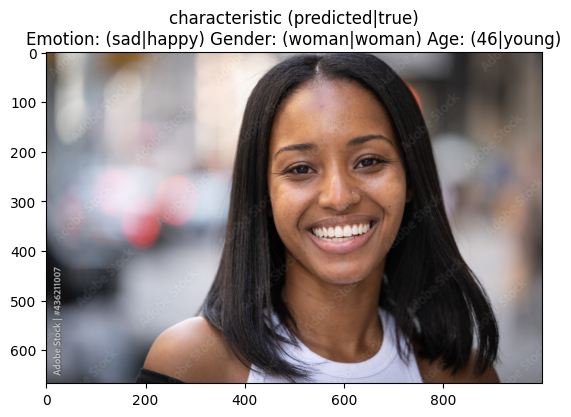

In [4]:
img_paths = '/home/hualcosa/Documents/iu_project_edge_ai/evaluation_images'
img_paths = [os.path.join(img_paths, i) for i in os.listdir(img_paths)]
emotion_labels = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]
gender_labels = ["woman", "man"]
# lists to store the compaisions between the predicted and true labels
age_evals, gender_evals, emotion_evals = [], [], []

# Load the TFLite models
emotion_interpreter = tf.lite.Interpreter(model_path="/home/hualcosa/Documents/iu_project_edge_ai/project_files/artifacts/models/emotion_model.tflite")
age_interpreter = tf.lite.Interpreter(model_path="/home/hualcosa/Documents/iu_project_edge_ai/project_files/artifacts/models/age_model.tflite")
gender_interpreter = tf.lite.Interpreter(model_path="/home/hualcosa/Documents/iu_project_edge_ai/project_files/artifacts/models/gender_model.tflite")

# Allocate memory for the model
emotion_interpreter.allocate_tensors()
age_interpreter.allocate_tensors()
gender_interpreter.allocate_tensors()

# Get input and output tensors
emotion_input_details = emotion_interpreter.get_input_details()
emotion_output_details = emotion_interpreter.get_output_details()
age_input_details = age_interpreter.get_input_details()
age_output_details = age_interpreter.get_output_details()
gender_input_details = gender_interpreter.get_input_details()
gender_output_details = gender_interpreter.get_output_details()

for path in img_paths:
    # read image
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_orig = img.copy() 
    # the model expects data in float32 format
    img = img.astype('float32')
    # creating two separate image versions: One for the emotion model and one for the age and gender model
    img_gender_age = cv2.resize(img, (224,224))
    img_gender_age = img_gender_age.reshape(1, 224, 224, 3) / 255 # normalizing the img
    img_emotion = cv2.resize(img, (48,48))
    img_emotion = cv2.cvtColor(img_emotion, cv2.COLOR_RGB2GRAY)
    img_emotion = img_emotion.reshape(1, 48,48, 1) / 255 # normalizing the img

    # Set the input tensor
    emotion_interpreter.set_tensor(emotion_input_details[0]['index'], img_emotion)
    age_interpreter.set_tensor(age_input_details[0]['index'], img_gender_age)
    gender_interpreter.set_tensor(gender_input_details[0]['index'], img_gender_age)

    # Run the model
    emotion_interpreter.invoke()
    age_interpreter.invoke()
    gender_interpreter.invoke()

    # Get the output tensor
    emotion_output_data = emotion_interpreter.get_tensor(emotion_output_details[0]['index'])
    age_output_data = age_interpreter.get_tensor(age_output_details[0]['index'])
    gender_output_data = gender_interpreter.get_tensor(gender_output_details[0]['index'])

    # retrieving the original names from the file names:
    age_label, gender_label, emotion_label, _ = path.split('/')[-1].split("_")

    # appending the evaluations to the lists, so we can later compute the accuaracies of each deployed model
    age_evals.append(int(age_label == ("young" if age_output_data.argmax() < 65 else "elderly")))
    gender_evals.append(int(gender_label == gender_labels[gender_output_data.argmax()]))
    emotion_evals.append(int(emotion_label == emotion_labels[emotion_output_data.argmax()]))

    plt.imshow(img_orig)
    plt.title(f"characteristic (predicted|true)\nEmotion: ({emotion_labels[emotion_output_data.argmax()]}|{emotion_label}) Gender: ({gender_labels[gender_output_data.argmax()]}|{gender_label}) Age: ({age_output_data.argmax()}|{age_label})")
    plt.show()

In [5]:
print(f"The expected accuracy for the deployed emotion model is: {100 * sum(emotion_evals)/ len(emotion_evals)} %")
print(f"The expected accuracy for the deployed gender model is: {100 * sum(gender_evals)/ len(gender_evals)} %")
print(f"The expected accuracy for the deployed emotion model is: {100 * sum(age_evals)/ len(age_evals)} %")


The expected accuracy for the deployed emotion model is: 29.166666666666668 %
The expected accuracy for the deployed gender model is: 50.0 %
The expected accuracy for the deployed emotion model is: 50.0 %


# Final Observations:
### original age model:
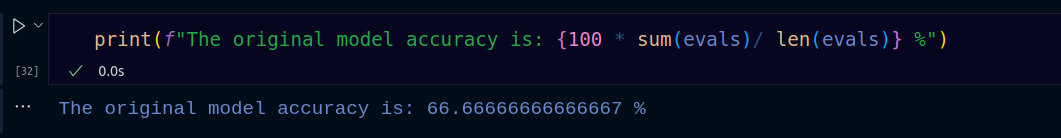
### original gender model:
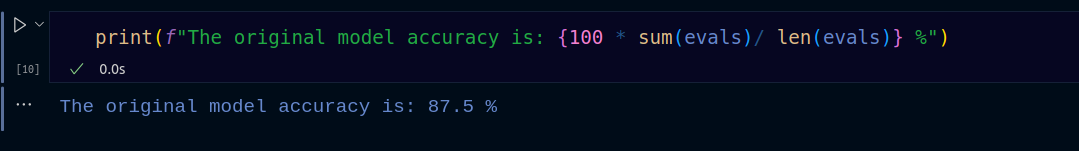
### original emotion model:
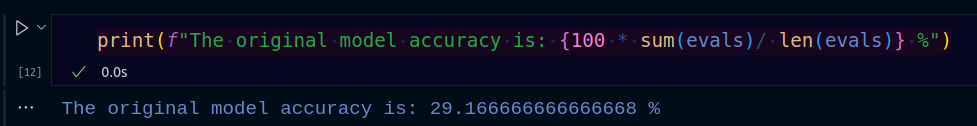


we can observe that the age and gender models needed to go through quantization process to reduce some of its complexity before deployment. This affected the resulting tf-lite models performances, reducing their accuracy  compared to the original tensorflow models. The emotion model on the other hand
performs equally in both scenarios, because it is smaller than the two other models and was not necessary to pass it through 
quantization.